In [1]:
import pyspark
import pandas as pd
from pyspark.sql.functions import *
from pyspark.sql import SparkSession
import pyspark.sql.functions as f

import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np
import math
import datetime
import seaborn as sns
import warnings

spark = SparkSession.builder.appName("bigdata")\
                    .config("spark.some.config.option", "some-value")\
                    .getOrCreate()

In [2]:
%run data.py
warnings.filterwarnings("ignore")  # ignore warnings

In [3]:
# filter the dataframe, just leave the cases, deaths and ever-hospitalized
nycBorough = fetchData(nyc_his_boro_url)
borough = nycBorough[(nycBorough.type == "cases") | (nycBorough.type == "deaths") | (nycBorough.type == "ever-hospitalized")]

# change the timestamp to date and rearrange the columns
borough[["date","time"]] = borough["timestamp"].str.split("T", expand = True)
borough = borough[["date","type","bronx","brooklyn","manhattan","queens","staten_island","unknown","total"]]
borough["date"] = pd.to_datetime(borough['date'])
borough.head(3)

,date,type,bronx,brooklyn,manhattan,queens,staten_island,unknown,total
0,2020-03-12,cases,10,24,25,17,5,7,88
1,2020-03-13,cases,13,24,35,26,5,34,137
2,2020-03-15,cases,21,53,72,78,16,29,269


In [4]:
# get the latest data for condirmed cases, deaths and hospitalized
update = borough.tail(3)
update.set_index(["type"], inplace = True) 
update

,date,bronx,brooklyn,manhattan,queens,staten_island,unknown,total
type,,,,,,,,
cases,2020-05-05,39587,46139,21470,53692,12311,89,173288
deaths,2020-05-05,3046,4194,1822,4213,655,8,13938
ever-hospitalized,2020-05-05,10147,11641,5917,14003,1948,20,43676


In [5]:
def getTimeRange(inputeData):
    firstRow = inputeData.head(1)
    start_date = firstRow.iloc[[0],[0]].values[0][0]
    start_date = pd.to_datetime(str(start_date)).strftime("%Y.%m.%d")

    lastRow = inputeData.tail(1)
    latest_date = lastRow.iloc[[0],[0]].values[0][0]
    latest_date = pd.to_datetime(str(latest_date)).strftime("%Y.%m.%d")

    print("Update: " + latest_date + " (from " + latest_date + ")")

In [6]:
# regional all data generalize function
def regionData (regionSourceData, region):
    case = regionSourceData[(regionSourceData.type == "cases")]
    death = regionSourceData[(regionSourceData.type == "deaths")]
    hosp = regionSourceData[(regionSourceData.type == "ever-hospitalized")]
    
    case.rename(columns = {region:"cases"}, inplace = True)
    case.drop(columns = ["type"], inplace = True)
    
    death.rename(columns = {region:"deaths"}, inplace= True)
    death.drop(columns = ["type"], inplace = True)

    hosp.rename(columns = {region:"ever-hospitalized"}, inplace = True)
    hosp.drop(columns = ["type"], inplace = True)
    
    mergeHelper = pd.merge(case, hosp, how = "outer", on = ["date"])
    regionAllData = pd.merge(mergeHelper, death, how = "outer", on = ["date"])
    regionAllData = regionAllData.fillna(0)
    regionAllData[["cases", "ever-hospitalized", "deaths"]] \
                    = regionAllData[["cases", "ever-hospitalized", "deaths"]].astype(int)
    
    return regionAllData

In [7]:
# regional plot generalize function
def regionPlot (regionAllData, region):
    df = regionAllData
    df["date"] = df["date"].astype(np.str_)
    df["date"] = pd.to_datetime(df["date"])
    df=df.set_index("date")

    df[["cases","ever-hospitalized","deaths"]].plot.area(stacked = False,cmap = "tab10_r")
    plt.title(region.capitalize() + " COVID-19 Data", fontsize = 20)
    plt.legend()
    plt.show()

# NYC COVID-19 Summary

In [8]:
# Summary data updated date 
getTimeRange(borough)

Update: 2020.05.05 (from 2020.05.05)


In [9]:
# NYC summary 
# rearrange col and row
nycSummary = update.drop(columns = ["date"])
cm = sns.light_palette("#66cccc", as_cmap = True)
df1 = nycSummary.stack()
df2 = df1.unstack(0)
df2.style.background_gradient(cmap = cm)

type,cases,deaths,ever-hospitalized
bronx,39587,3046,10147
brooklyn,46139,4194,11641
manhattan,21470,1822,5917
queens,53692,4213,14003
staten_island,12311,655,1948
unknown,89,8,20
total,173288,13938,43676


# NYC COVID-19 Summary by Date

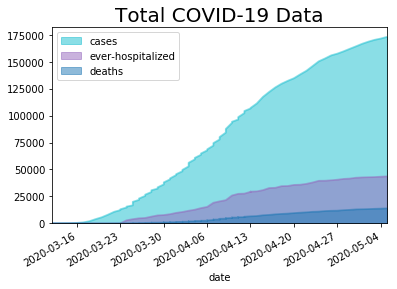

In [10]:
# case, death, haspitalized data for NYC 
nycData = borough[["date","type","total"]] 
region = "total"
nycAllData = regionData (nycData, region)
regionPlot (nycAllData, region)

# Data for Each Borough

In [11]:
# Cases / Deaths / Hosplitalized Data for Each Borough

# Bronx Data

In [12]:
# case, death, haspitalized data for bronx 
bronxData = borough[["date","type","bronx"]] 
region = "bronx"
bronxAllData = regionData (bronxData, region)
bronxAllData.tail(5)

,date,cases,ever-hospitalized,deaths
111,2020-05-01,38099,9873,2868
112,2020-05-02,38599,9941,2886
113,2020-05-03,38973,10007,2936
114,2020-05-04,39239,10084,2997
115,2020-05-05,39587,10147,3046


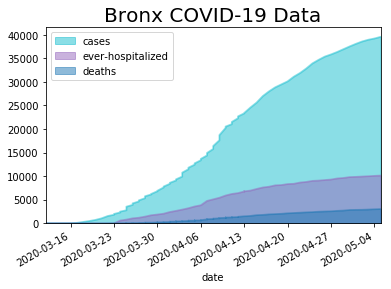

In [13]:
regionPlot (bronxAllData, region)

# Brooklyn Data

In [14]:
# case, death, haspitalized data for brooklyn
brooklynData = borough[["date","type","brooklyn"]] 
region = "brooklyn"
brooklynAllData = regionData (brooklynData, region)
brooklynAllData.tail(5)

,date,cases,ever-hospitalized,deaths
111,2020-05-01,44303,11400,3952
112,2020-05-02,44867,11437,4014
113,2020-05-03,45341,11469,4080
114,2020-05-04,45637,11565,4127
115,2020-05-05,46139,11641,4194


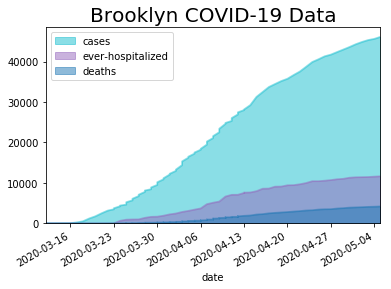

In [15]:
regionPlot (brooklynAllData, region)

# Manhattan Data

In [16]:
# case, death, haspitalized data for manhattan
manhattanData = borough[["date","type","manhattan"]]
region = "manhattan"
manhattanAllData = regionData (manhattanData, region)
manhattanAllData.tail(5)

,date,cases,ever-hospitalized,deaths
111,2020-05-01,20693,5787,1722
112,2020-05-02,20892,5825,1752
113,2020-05-03,21125,5836,1774
114,2020-05-04,21287,5869,1797
115,2020-05-05,21470,5917,1822


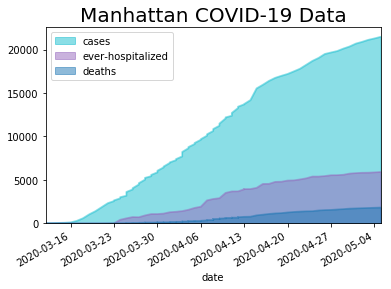

In [17]:
regionPlot (manhattanAllData, region)

# Queens Data

In [18]:
# case, death, haspitalized data for queens
queensData = borough[["date","type","queens"]] 
region = "queens"
queensAllData = regionData (queensData, region)
queensAllData.tail(5)

,date,cases,ever-hospitalized,deaths
111,2020-05-01,51709,13738,3993
112,2020-05-02,52305,13782,4035
113,2020-05-03,52845,13805,4102
114,2020-05-04,53243,13915,4149
115,2020-05-05,53692,14003,4213


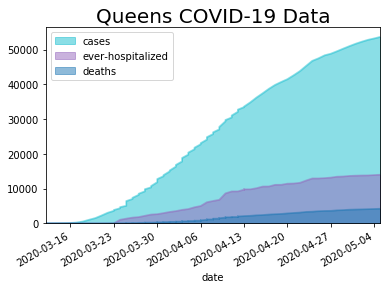

In [19]:
regionPlot (queensAllData, region)

# Staten Island Data

In [20]:
# case, death, haspitalized data for staten_island
staten_islandData = borough[["date","type","staten_island"]] 
region = "staten_island"
staten_islandAllData = regionData (staten_islandData, region)
staten_islandAllData.tail(5)

,date,cases,ever-hospitalized,deaths
111,2020-05-01,11999,1898,613
112,2020-05-02,12101,1905,624
113,2020-05-03,12169,1909,636
114,2020-05-04,12235,1931,646
115,2020-05-05,12311,1948,655


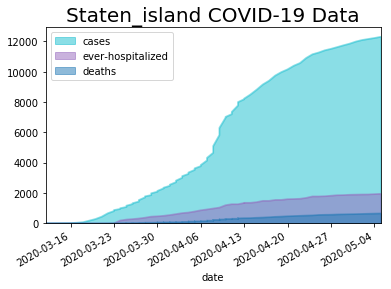

In [21]:
regionPlot (staten_islandAllData, region)

# NYC Cases and Tasted Data

In [22]:
# filter the dataframe, just leave the date and number of tasted
nycTestSource = fetchData(nyc_his_state_url)
nycTest = nycTestSource[["timestamp","nyc_tested","nyc_cases"]]
nycTest = nycTest.fillna(0)
nycTest[["nyc_tested","nyc_cases"]] = nycTest[["nyc_tested","nyc_cases"]].astype(int)

nycTest[["date","time"]] = nycTest["timestamp"].str.split("T", expand = True)
nycTest = nycTest[["date","nyc_tested","nyc_cases"]]
nycTest["date"] = pd.to_datetime(nycTest["date"])

# NYC test data update date
getTimeRange(nycTest)

Update: 2020.05.06 (from 2020.05.06)


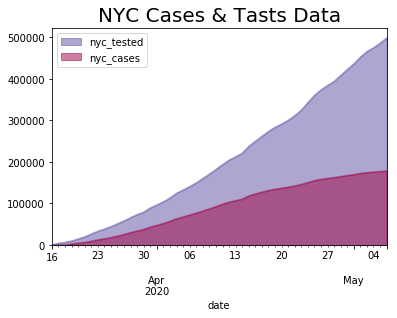

In [23]:
df = nycTest
df["date"] = df["date"].astype(np.str_)
df["date"] = pd.to_datetime(df["date"])
df = df.set_index("date")

df[["nyc_tested","nyc_cases"]].plot.area(stacked = False,cmap = "Spectral_r")
plt.title("NYC Cases & Tasts Data", fontsize = 20)
plt.legend()
plt.show()

In [184]:
# cases by age
casesAge = fetchData(nyc_his_age_url)

# filter the dataframe, just leave the date and number of tasted
ageGroup = casesAge[["timestamp","type","ages_0_17","ages_18_44","ages_45_64","ages_65_74","ages_75_older","unknown"]]
ageGroup[["date","time"]] = ageGroup["timestamp"].str.split("T", expand = True)
ageGroup = ageGroup[["date","type","ages_0_17","ages_18_44","ages_45_64","ages_65_74","ages_75_older","unknown"]]
ageGroup["date"] = pd.to_datetime(ageGroup["date"])

# summary of age group
ageGroupCase = ageGroup[(ageGroup.type == "cases")]
ageGroupCaseUpdate = ageGroupCase.tail(1)

ageGroupDeath = ageGroup[(ageGroup.type == "deaths")]
ageGroupDeathUpdate = ageGroupDeath.tail(1)

frames = [ageGroupCaseUpdate, ageGroupDeathUpdate]
ageGroupUpdate = pd.concat(frames).drop(columns=["date"])
ageGroupUpdate.set_index(["type"], inplace = True) 

# Cases by Age Group

In [25]:
# cases and deaths for age group
# rearrange col and row
cm = sns.light_palette("#d1574c", as_cmap = True)
df1 = ageGroupUpdate.stack()
df2 = df1.unstack(0)
df2.style.background_gradient(cmap = cm)

type,cases,deaths
ages_0_17,4188,6
ages_18_44,63726,557
ages_45_64,63670,3119
ages_65_74,21590,3458
ages_75_older,19779,6797
unknown,335,1


In [ ]:
# test

In [80]:
test = nycAllData[["date","cases"]]
test.head(5)

,date,cases
0,2020-03-12,88
1,2020-03-13,137
2,2020-03-15,269
3,2020-03-16,464
4,2020-03-17,923


In [183]:
# t:time   t0:initial time    P0:initial_value    K:capacity  r:increase_rate
def logistic_increase_function(t,K,P0,r):
    t0 = 0
    exp_value=np.exp(r*(t-t0))
    return (K*exp_value*P0)/(K+(exp_value-1)*P0)
 
fast_r=0.02
slow_r=0.03

def faster_logistic_increase_function(t,K,P0,):
    return logistic_increase_function(t,K,P0,r=fast_r)
 
def slower_logistic_increase_function(t,K,P0,):
    return logistic_increase_function(t,K,P0,r=slow_r)

In [180]:
days = len(test)
t = np.arange(0,days)
P = np.array(test["cases"])
days

116

In [181]:
popt_fast, pcov_fast = curve_fit(faster_logistic_increase_function, t, P)
popt_slow, pcov_slow = curve_fit(slower_logistic_increase_function, t, P)

P_predict_fast= faster_logistic_increase_function(t,popt_fast[0],popt_fast[1])
P_predict_slow = slower_logistic_increase_function(t,popt_slow[0],popt_slow[1])

tomorrow= np.arange(days,days+10)
tomorrow_predict_fast=logistic_increase_function(tomorrow,popt_fast[0],popt_fast[1],r=fast_r)
tomorrow_predict_slow=logistic_increase_function(tomorrow,popt_slow[0],popt_slow[1],r=slow_r)

test:
117
188706.2948489351
174417.7157651312
118
192518.41310941768
176556.91612563498


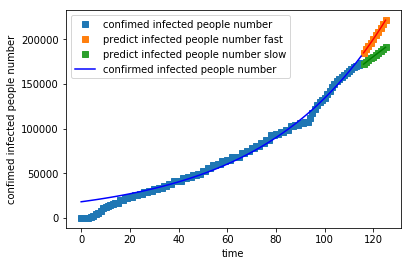

In [182]:
plot1 = plt.plot(t, P, 's',label="confimed infected people number")
plot2 = plt.plot(tomorrow, tomorrow_predict_fast, 's',label='predict infected people number fast')
plot3 = plt.plot(tomorrow, tomorrow_predict_fast, 'r')
plot4 = plt.plot(tomorrow, tomorrow_predict_slow, 's',label='predict infected people number slow')
plot5 = plt.plot(tomorrow, tomorrow_predict_slow, 'g')
plot6 = plt.plot(t, P_predict_fast, 'b',label='confirmed infected people number')
 
plt.xlabel('time')
plt.ylabel('confimed infected people number')
 
plt.legend(loc=0)
 
day2 = days +1
day3 = days +2

print("test:")
print(day2)
print(faster_logistic_increase_function(np.array(day2),popt_fast[0],popt_fast[1]))
print(slower_logistic_increase_function(np.array(day2),popt_slow[0],popt_slow[1]))
 
print(day3)
print(faster_logistic_increase_function(np.array(day3),popt_fast[0],popt_fast[1]))
print(slower_logistic_increase_function(np.array(day3),popt_slow[0],popt_slow[1]))
 
plt.show()
